# POTATO LEAF DISEASE CLASSIFICATION
- Based on three classes (Early Blight, Late Blight and Healthy)

## Import all the required modules and dependencies

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from PIL import Image



## Set the constant values

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

## Import the dataset

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "c:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem\ML_Project/MCA Sem 1 ML Project-20241125T080316Z-001/MCA Sem 1 ML Project/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5702 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

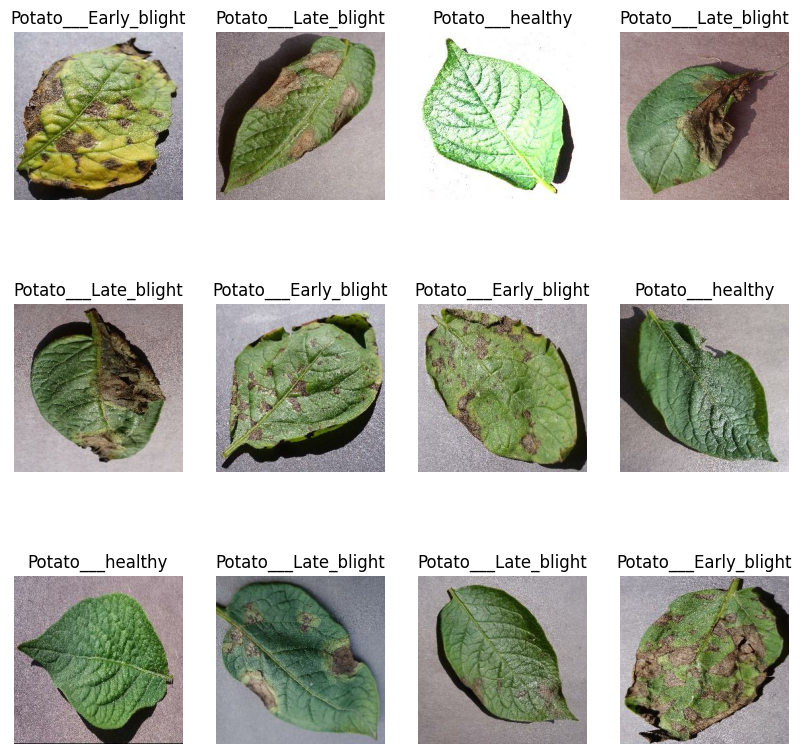

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Quantization**

In [10]:


def quantize_image_region(image, num_levels=5):
    image = tf.cast(image, tf.float32)
    image_min = tf.reduce_min(image)
    image_max = tf.reduce_max(image)

    image = (image - image_min) / (image_max - image_min)

    image = tf.floor(image * num_levels) / num_levels

    image = image * (image_max - image_min) + image_min
    return image

def quantize_image_into_parts(image_path, num_levels=5):

    img = Image.open(image_path)
    img_np = np.array(img)
    height, width, channels = img_np.shape


    part_coords = {
        1: (0, 0, width // 2, height // 2),  
        2: (width // 2, 0, width, height // 2),  
        3: (width // 2, height // 2, width, height),  
        4: (0, height // 2, width // 2, height), 
        5: (
            width // 4, height // 4,  
            3 * width // 4, 3 * height // 4
        ),
    }

    quantized_parts = {}

    for part, (x1, y1, x2, y2) in part_coords.items():
        region = img_np[y1:y2, x1:x2]
        quantized_region = quantize_image_region(region, num_levels)
        quantized_parts[part] = quantized_region.numpy()

    return quantized_parts


In [11]:
dataset_dir = "/content/drive/MyDrive/MCA Sem 1 ML Project-20241125T080316Z-001/MCA Sem 1 ML Project/train"
quantized_dataset_dir = "/content/drive/MyDrive/quantized_dataset" 
os.makedirs(quantized_dataset_dir, exist_ok=True)


for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    quantized_class_dir = os.path.join(quantized_dataset_dir, class_name)
    os.makedirs(quantized_class_dir, exist_ok=True)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        try:
          quantized_parts = quantize_image_into_parts(image_path)
          for part, quantized_image in quantized_parts.items():
              quantized_image = quantized_image.astype(np.uint8)
              new_image_name = f"{image_name[:-4]}_part{part}{image_name[-4:]}"
              new_image_path = os.path.join(quantized_class_dir, new_image_name)
              Image.fromarray(quantized_image).save(new_image_path)
        except Exception as e:
          print(f"Error processing image {image_name}: {e}")

In [6]:

import tensorflow as tf
quantized_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem/ML_Project/quantized_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = quantized_dataset.class_names
class_names

Found 28530 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

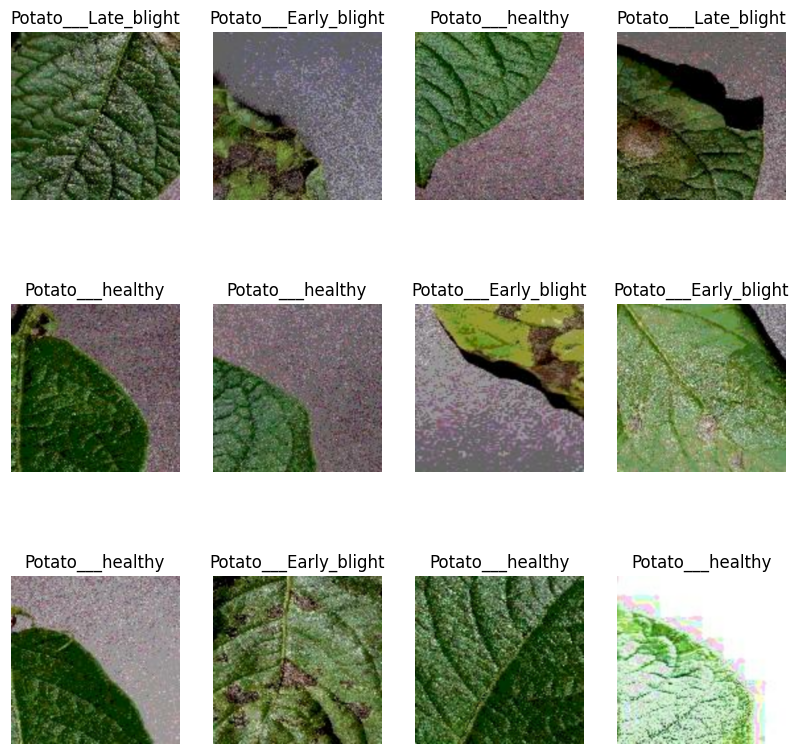

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in quantized_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()

## Spliting the Dataset (80-10-10)

In [7]:
def split_dataset(dataset, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    val_size = int(dataset_size * val_size)
    test_size = int(dataset_size * test_size)
    train_dataset = dataset.skip(val_size + test_size)
    val_dataset = dataset.take(val_size)
    test_dataset = dataset.skip(val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(quantized_dataset)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 714
Validation dataset size: 89
Test dataset size: 89


## Cache, Shuffle, and Prefetch the Dataset

---



In [8]:
def split_dataset(dataset, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    val_size = int(dataset_size * val_size)
    test_size = int(dataset_size * test_size)

    train_dataset = dataset.skip(val_size + test_size)
    val_dataset = dataset.take(val_size)
    test_dataset = dataset.skip(val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(quantized_dataset)


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Building the Model
(Resize, Rescale and Augmentation)

In [7]:
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# CNN MODEL ARCHITECTURE

In [9]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),  
    resize_and_rescale,              
    data_augmentation,              
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [10]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_path = 'C:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem/ML_Project/first_potatoleaf_model.h5'

model = tf.keras.models.load_model(model_path)

In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,749 (717.77 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Compiling the Model
### (Using adam as the optimizer)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_dataset,  
    batch_size=BATCH_SIZE,
    validation_data=val_dataset, 
    verbose=1,
    epochs=10,
)

Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 922s 1s/step - accuracy: 0.8574 - loss: 0.4474 - val_accuracy: 0.9487 - val_loss: 0.1455
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 803s 1s/step - accuracy: 0.9401 - loss: 0.1595 - val_accuracy: 0.9561 - val_loss: 0.1339
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 658s 921ms/step - accuracy: 0.9503 - loss: 0.1355 - val_accuracy: 0.9628 - val_loss: 0.1060
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 665s 931ms/step - accuracy: 0.9540 - loss: 0.1246 - val_accuracy: 0.9614 - val_loss: 0.1130
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 644s 903ms/step - accuracy: 0.9620 - loss: 0.1032 - val_accuracy: 0.9603 - val_loss: 0.1036
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 634s 888ms/step - accuracy: 0.9673 - loss: 0.0901 - val_accuracy: 0.9610 - val_loss: 0.1063
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 626s 877ms/step - accuracy: 0.9679 - loss: 0.0874 - val_accuracy: 0.9659 - val_loss: 0.0977
Epoch 8/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 618s 866ms/step - accuracy: 0.9659 - loss:

In [15]:
scores = model.evaluate(train_dataset)
scores

714/714 ━━━━━━━━━━━━━━━━━━━━ 216s 303ms/step - accuracy: 0.9808 - loss: 0.0481


[0.04796523600816727, 0.9811684489250183]

In [16]:
accuracy = scores[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.12%


### A 99.18% accuracy is achieved using CNN Model

# Plotting the Accuracy and Loss Curves

In [17]:
history

In [18]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 714}

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
history.history['accuracy'][:5]

[0.9050538539886475,
 0.9427607655525208,
 0.9503372311592102,
 0.9523955583572388,
 0.9609792232513428]

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

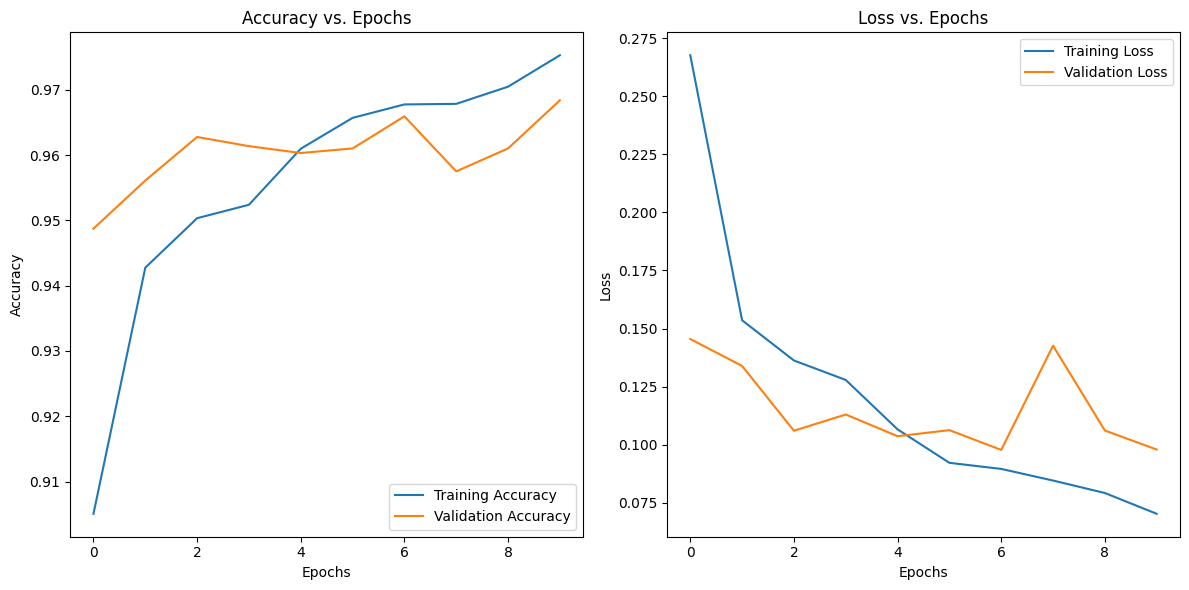

In [22]:
epochs_range = range(len(acc))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## SAVING THE MODEL

In [23]:
model.save('final_potato_leaf_model.h5')

## LOADING THE SAVED MODEL (FOR CHECKING)

In [1]:
from tensorflow.keras.models import load_model

loaded_model = load_model('final_potato_leaf_model.h5')

## TESTING A SAMPLE IMAGE FROM TEST SPLIT

First image to predict:


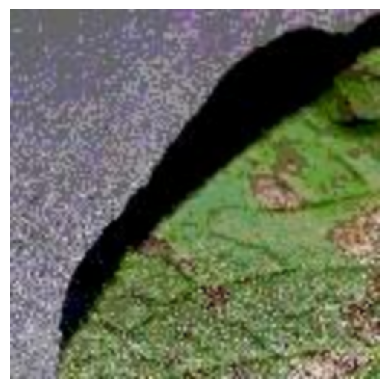

Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Predicted label: Potato___Early_blight


In [10]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    print("Actual label:", class_names[first_label])
    batch_prediction = loaded_model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0]) 
    print("Predicted label:", class_names[predicted_label])

# RUNNING AN INFERENCE OF FEW SAMPLE IMAGES

In [13]:
def predict(model, img):
    img_array = tf.expand_dims(img, axis=0)

    predictions = loaded_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


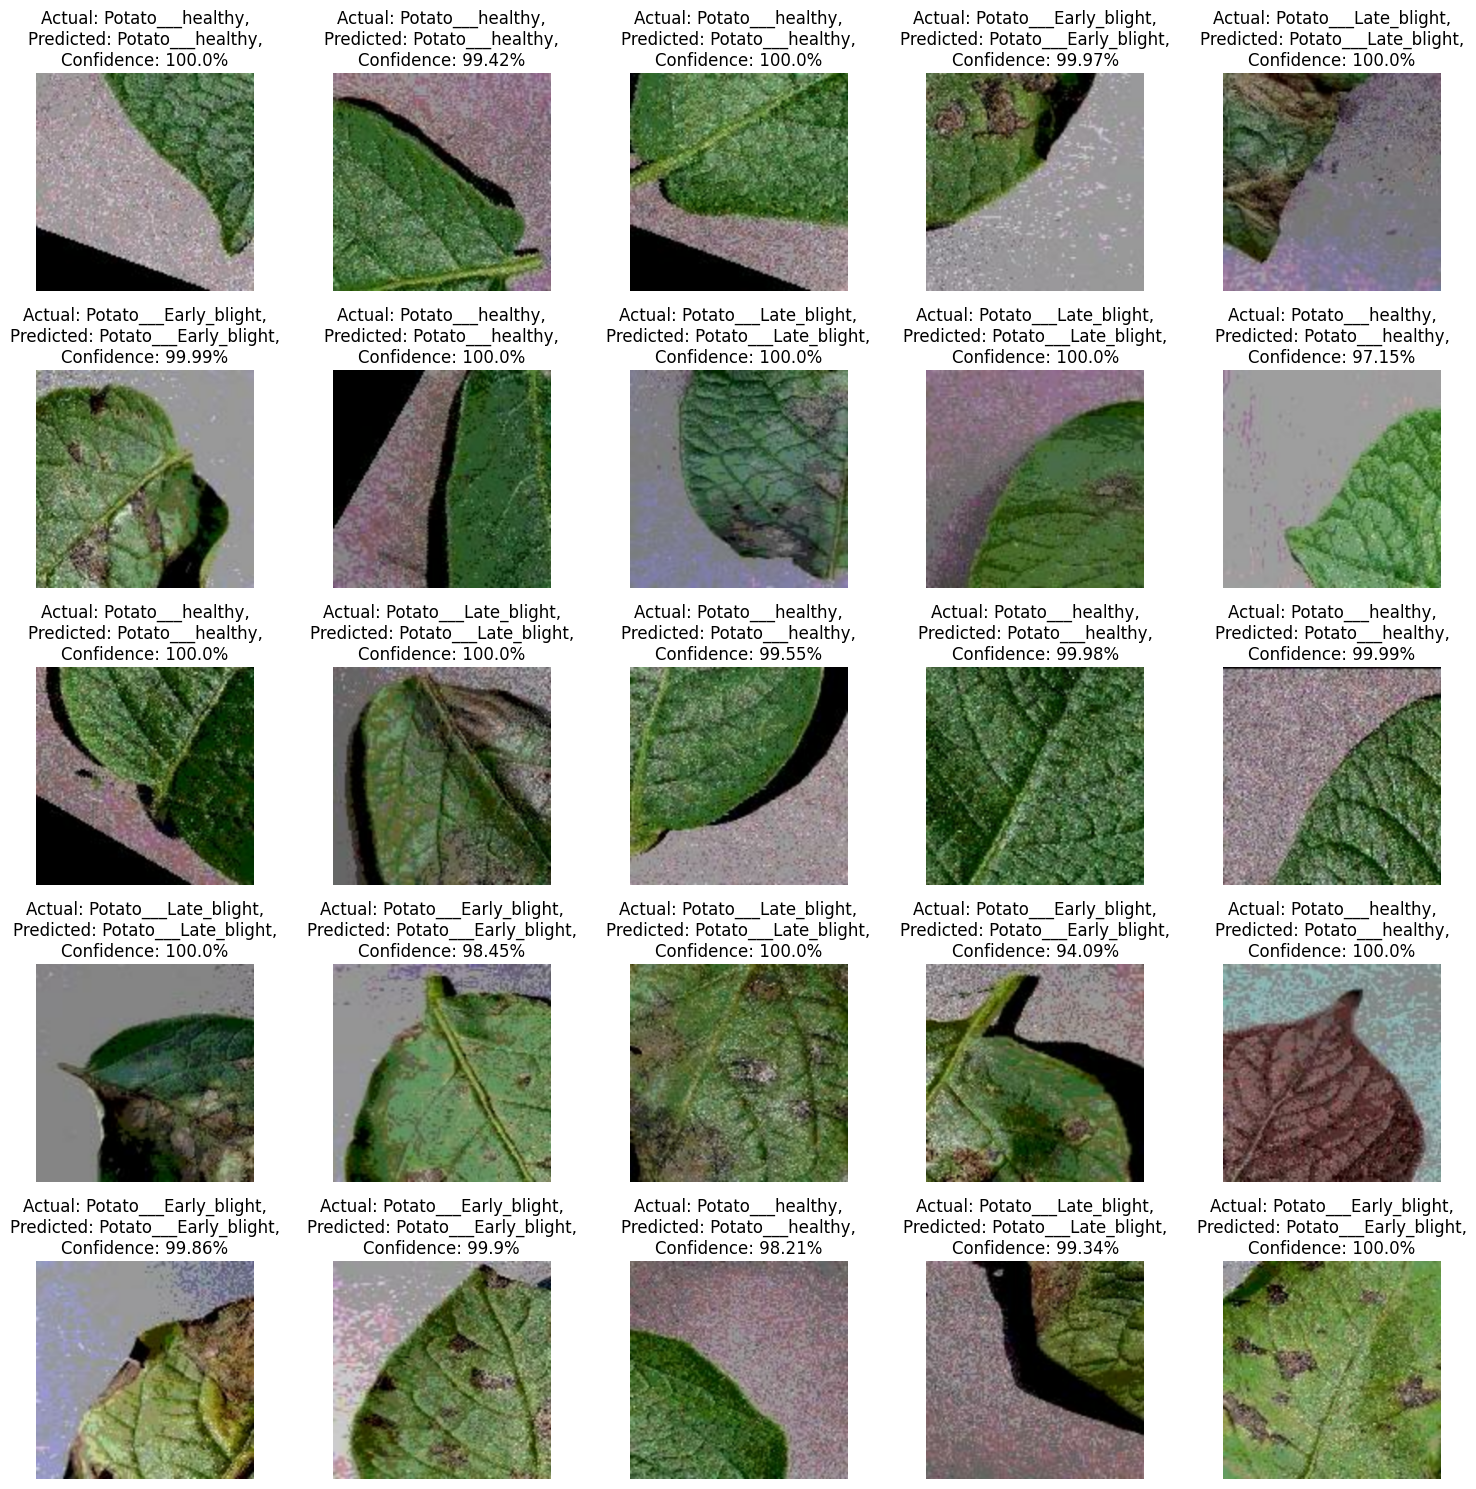

In [15]:
num_images = 25
rows = int(num_images**0.5)
cols = int(np.ceil(num_images / rows))

plt.figure(figsize=(15, 15))
image_count = 0

for images, labels in test_dataset:
    for i in range(len(images)):
        if image_count >= num_images:
            break
        ax = plt.subplot(rows, cols, image_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(loaded_model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
        image_count += 1
    if image_count >= num_images:
        break

plt.tight_layout()
plt.show()

## PLOTTING THE CONFUSION MATRIX
- Diagonal values show correct predictions.
- Off-diagonal values show misclassifications.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

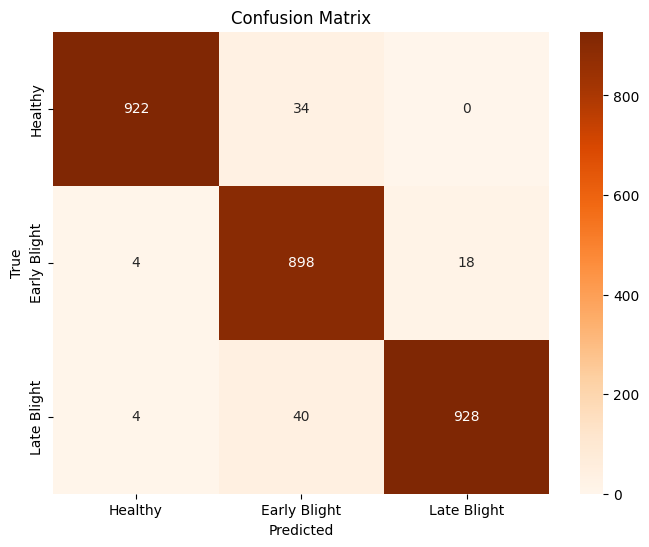

[[922  34   0]
 [  4 898  18]
 [  4  40 928]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       956
           1       0.92      0.98      0.95       920
           2       0.98      0.95      0.97       972

    accuracy                           0.96      2848
   macro avg       0.97      0.97      0.96      2848
weighted avg       0.97      0.96      0.97      2848



In [28]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score, classification_report, confusion_matrix

class_names = ['Healthy', 'Early Blight', 'Late Blight']

true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    batch_predictions = loaded_model.predict(images)
    predicted_labels_batch = np.argmax(batch_predictions, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_labels_batch)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(classification_report(true_labels, predicted_labels))

# **Prediction on original Data**

In [29]:
original_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "c:/Users/Rohan Dutta/OneDrive/Attachments/MCA-1st Sem\ML_Project/MCA Sem 1 ML Project-20241125T080316Z-001/MCA Sem 1 ML Project/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5702 files belonging to 3 classes.


In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(original_dataset)

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
len(train_ds)

143

In [34]:
len(val_ds)

17

In [35]:
len(test_ds)

19

First image to predict:


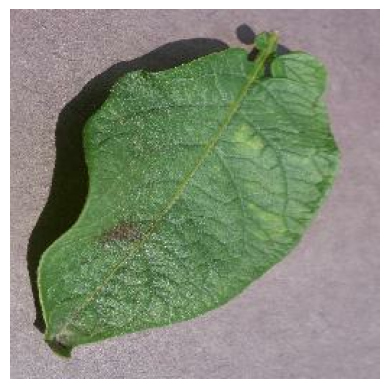

Actual label: Early Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Predicted label: Early Blight


In [36]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    print("Actual label:", class_names[first_label])
    batch_prediction = loaded_model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])  
    print("Predicted label:", class_names[predicted_label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


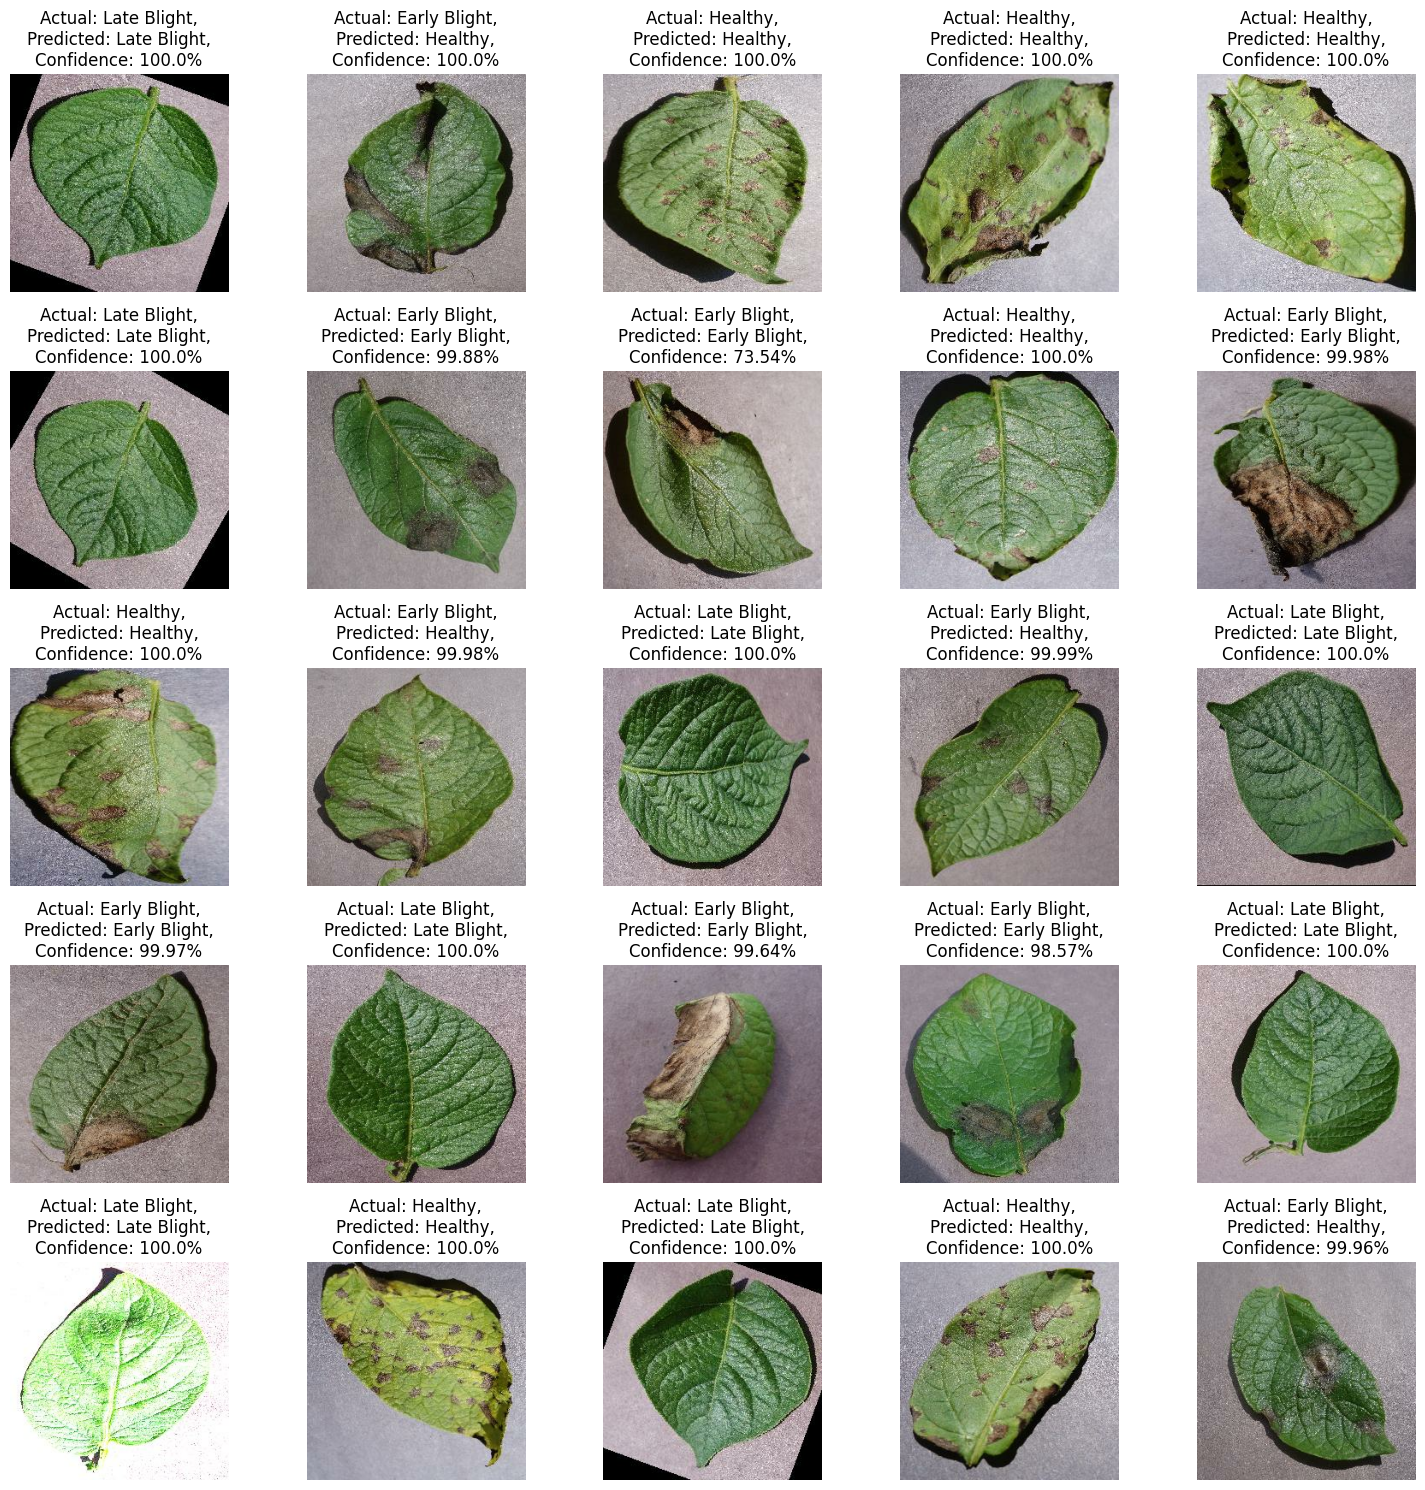

In [37]:
num_images = 25
rows = int(num_images**0.5)
cols = int(np.ceil(num_images / rows))

plt.figure(figsize=(15, 15))
image_count = 0

for images, labels in test_ds:
    for i in range(len(images)):
        if image_count >= num_images:
            break
        ax = plt.subplot(rows, cols, image_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(loaded_model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
        image_count += 1
    if image_count >= num_images:
        break

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


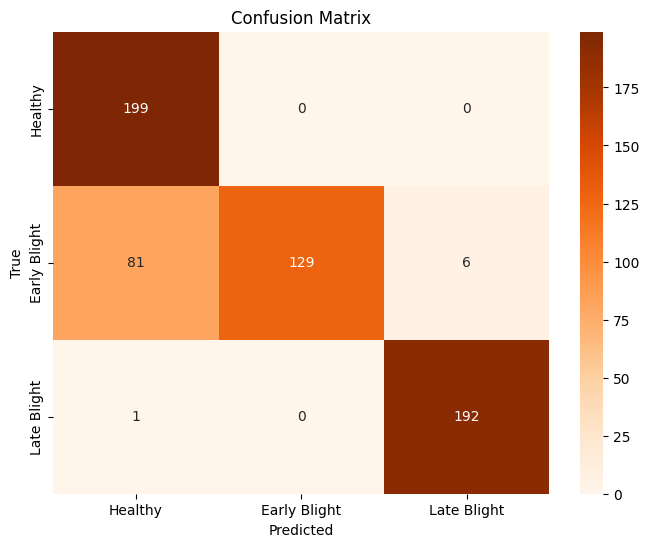

[[199   0   0]
 [ 81 129   6]
 [  1   0 192]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       199
           1       1.00      0.60      0.75       216
           2       0.97      0.99      0.98       193

    accuracy                           0.86       608
   macro avg       0.89      0.86      0.85       608
weighted avg       0.89      0.86      0.85       608



In [38]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score, classification_report, confusion_matrix

class_names = ['Healthy', 'Early Blight', 'Late Blight']

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    batch_predictions = loaded_model.predict(images)
    predicted_labels_batch = np.argmax(batch_predictions, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_labels_batch)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(classification_report(true_labels, predicted_labels))